In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import torch
import warnings
import matplotlib.pyplot as plt
from XBO._utils import TensorManager
tm = TensorManager()
warnings.filterwarnings('ignore')

## 1. Problem definition
Let's get started with the toy example of two-dimensional Branin function.<br>
More details can be found [here](https://www.sfu.ca/~ssurjano/branin.html)<br>
- bounds: -2 from 3
- variable type: continuous
- ground truth X: [-1.02543108, -1.02543108]
- ground truth Y: 10.6043
- optimisation: maximisation

In [2]:
def BraninFunction(x):
    x = torch.atleast_2d(x)
    return ((x.sin() + (3*x).cos()/2).square() / ((x/2).square()+0.3)).prod(axis=1)

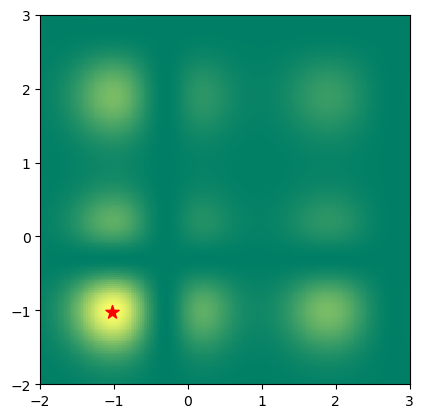

In [3]:
lower_limit = -2
upper_limit = 3
colour_map = 'summer'
resolution = 200
ground_truth = torch.tensor([-1.02543108, -1.02543108])

def get_plotting_domain():
    x = torch.linspace(lower_limit, upper_limit, resolution)
    y = torch.linspace(lower_limit, upper_limit, resolution)
    x_grid, y_grid = torch.meshgrid(x, y)
    X_grid = torch.dstack([x_grid, y_grid]).reshape(resolution**2, 2)
    return tm.standardise_tensor(X_grid)

def plot_function(data, ax):
    data = tm.numpy(data).reshape(resolution, resolution)
    image = ax.imshow(
        data,
        cmap=plt.get_cmap(colour_map),
        vmin=data.min(),
        vmax=data.max(),
        extent=[lower_limit, upper_limit, lower_limit, upper_limit],
        interpolation='nearest',
        origin='lower',
    )
    ax.scatter(ground_truth[1], ground_truth[0], s=100, marker="*", color="red")

def plot_white(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=10, color="white")

def plot_black(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=30, marker="+", color="black")
    
fig, ax = plt.subplots()
Xgrid = get_plotting_domain()
Ygrid = BraninFunction(Xgrid)
plot_function(Ygrid, ax)
plt.show()

## 2. Define domain
Next, we define the domain of interest.
We set domain as uniform distribution bounded -2 from 3.

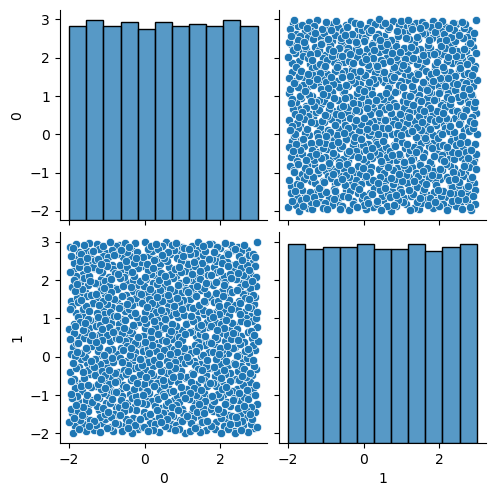

In [4]:
import seaborn as sns
import pandas as pd

# set bounds
n_dims = 2                          # number of dimensions
mins = lower_limit * torch.ones(n_dims)
maxs = upper_limit * torch.ones(n_dims)
bounds = torch.vstack([mins, maxs]) # bounds

# set domain
from XBO._prior import Uniform    # Import prior from SOBER libraries
domain = Uniform(bounds)
true_function = BraninFunction

# visualise domain
samples = domain.sample(1000)
sns.pairplot(pd.DataFrame(tm.numpy(samples)))
plt.show()

## 3. Preferential learning
Next, we try to learn the prior knowledge of human user.

- You will get the pair of points (X0, X1).
- You need to answer which you think larger.
- Type "0" if you think f_true(X0) > f_true(X1).
- Otherwise type "1".
- If you are unsure, type "2".
- We will iterate this back and forth at $n_{discuss}$ times

In [5]:
from XBO._xbo import XBOwithHuman, StateManager
n_init_pref = 10      # number of initial random samples for preferential learning
n_init_obj = 30       # number of initial random samples for objective function

xbo = XBOwithHuman(domain, true_function)
dataset_obj, dataset_duel = xbo.initial_sampling(n_init_obj, n_init_pref)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode
Epoch: 1/10
X1 (random): tensor([1.1951, 1.8593])
X0 (random): tensor([-0.0465,  0.3758])
Type 0 or 1 which you think larger. Type 2 if unsure.0
You chose X0
Epoch: 2/10
X1 (random): tensor([-0.8785,  0.0237])
X0 (random): tensor([2.9437, 2.3708])
Type 0 or 1 which you think larger. Type 2 if unsure.1
You chose X1
Epoch: 3/10
X1 (random): tensor([1.9135, 1.0435])
X0 (random): tensor([ 1.3620, -1.3297])
Type 0 or 1 which you think larger. Type 2 if unsure.0
You chose X0
Epoch: 4/10
X1 (random): tensor([-0.3859, -0.8702])
X0 (random): tensor([-0.9605,  0.5827])
Type 0 or 1 which you think larger. Type 2 if unsure.1
You chose X1
Epoch: 5/10
X1 (random): tensor([-1.4615, -1.7793])
X0 (random): tensor([-1.6745, -1.8177])
Type 0 or 1 which you think larger. Type 2 if unsure.1
You chose X1
Epoch: 6/10
X1 (random): tensor([0.5275, 1.3063])
X0 (random): tensor([0.6893, 1.4227])
Type 0 or 1 which you think lar

## 4. Run CoExBO

In [6]:
n_iterations = 20     # number of iterations
seed = 0              # random seed for reproduce the results

# initial setting
torch.manual_seed(seed)
state = StateManager(n_dims=n_dims)

0) parameters: beta 5.657e-01 gamma 0.000e+00 sigma 1.000e-01
training models...
generating candidates...
X1 (normal UCB): tensor([-1.3091, -1.0416])
X0 (preference): tensor([-1.2845, -1.0667])
Do you need more explanation on the two candidates?
Type y if yes, otherwise type n as non
Do you want to know the attribution to each feature?
Type y if yes, otherwise type n as non
Do you want to visualise the GP on the plane where two candidates are placed?
Type y if yes, otherwise type n as non
Do you want to visualise the learnt preference model on the plane where two candidates are placed?
Type y if yes, otherwise type n as non
Type 0 or 1 which you think larger. Type 2 if unsure.0
You chose X0
Probability of correct selection: 1.29e-01 ± 3.36e-01
Estimated total correct selection rate of sure samples: 3.68e-01 ± 3.02e-01
Is your selection correct? Yes if 1: 1
Is your selection sure? Yes if 1: 1
31) Best value: 8.12381e+00
1) parameters: beta 8.000e-01 gamma 1.000e-02 sigma 5.000e-02
train

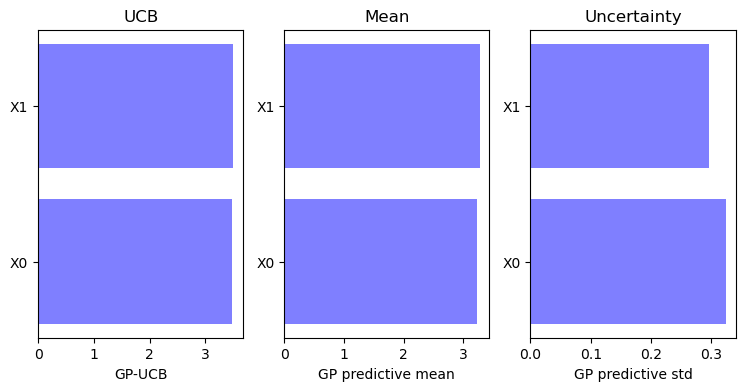

Do you want to know the attribution to each feature?
Type y if yes, otherwise type n as non
Do you want to visualise the GP on the plane where two candidates are placed?
Type y if yes, otherwise type n as non
Do you want to visualise the learnt preference model on the plane where two candidates are placed?
Type y if yes, otherwise type n as non
Type 0 or 1 which you think larger. Type 2 if unsure.1
You chose X1
Probability of correct selection: 9.06e-01 ± 2.64e-01
Estimated total correct selection rate of sure samples: 4.85e-01 ± 2.22e-01
Is your selection correct? Yes if 1: 1
Is your selection sure? Yes if 1: 1
32) Best value: 8.57076e+00
2) parameters: beta 9.798e-01 gamma 4.000e-02 sigma 3.333e-02
training models...
generating candidates...
X1 (normal UCB): tensor([-1.1093, -1.1307])
X0 (preference): tensor([-1.0686, -1.1158])
Do you need more explanation on the two candidates?
Type y if yes, otherwise type n as noy


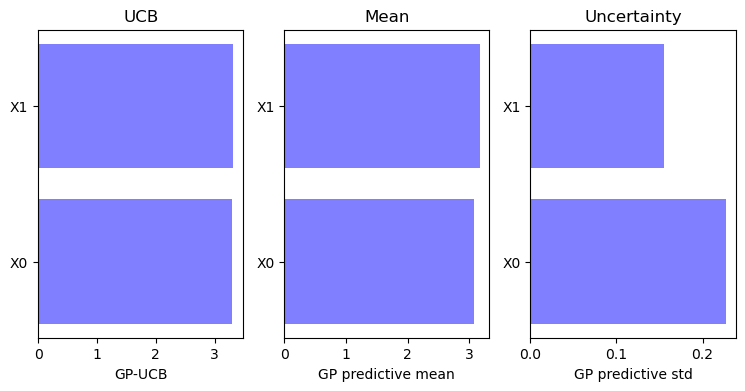

Do you want to know the attribution to each feature?
Type y if yes, otherwise type n as non
Do you want to visualise the GP on the plane where two candidates are placed?
Type y if yes, otherwise type n as nob
Do you want to visualise the learnt preference model on the plane where two candidates are placed?
Type y if yes, otherwise type n as non
Type 0 or 1 which you think larger. Type 2 if unsure.0
You chose X0
Probability of correct selection: 7.03e-02 ± 2.56e-01
Estimated total correct selection rate of sure samples: 4.57e-01 ± 2.67e-01
Is your selection correct? Yes if 1: 1
Is your selection sure? Yes if 1: 1
33) Best value: 1.01806e+01
3) parameters: beta 1.131e+00 gamma 9.000e-02 sigma 2.500e-02
training models...
generating candidates...
X1 (normal UCB): tensor([-0.9962, -1.0283])
X0 (preference): tensor([-0.9468, -1.0142])
Do you need more explanation on the two candidates?
Type y if yes, otherwise type n as noy


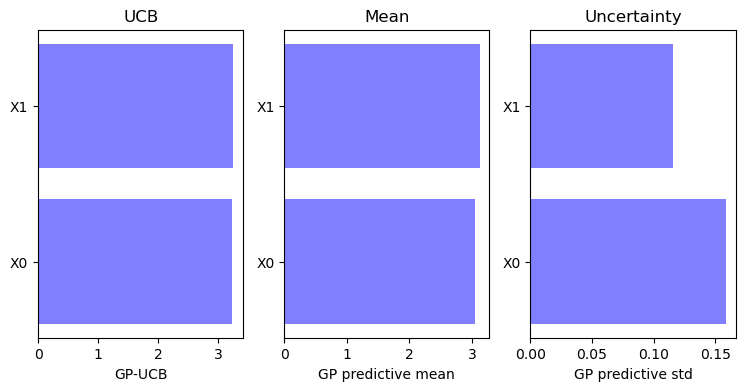

Do you want to know the attribution to each feature?
Type y if yes, otherwise type n as non
Do you want to visualise the GP on the plane where two candidates are placed?
Type y if yes, otherwise type n as non
Do you want to visualise the learnt preference model on the plane where two candidates are placed?
Type y if yes, otherwise type n as non
Type 0 or 1 which you think larger. Type 2 if unsure.1
You chose X1
Probability of correct selection: 9.64e-01 ± 1.85e-01
Estimated total correct selection rate of sure samples: 5.70e-01 ± 2.30e-01
Is your selection correct? Yes if 1: 1
Is your selection sure? Yes if 1: 1
34) Best value: 1.05658e+01
4) parameters: beta 1.265e+00 gamma 1.600e-01 sigma 2.000e-02
training models...
generating candidates...
X1 (normal UCB): tensor([-0.9368, -1.0599])
X0 (preference): tensor([-0.8997, -1.0628])
Do you need more explanation on the two candidates?
Type y if yes, otherwise type n as non
Do you want to know the attribution to each feature?
Type y if yes,

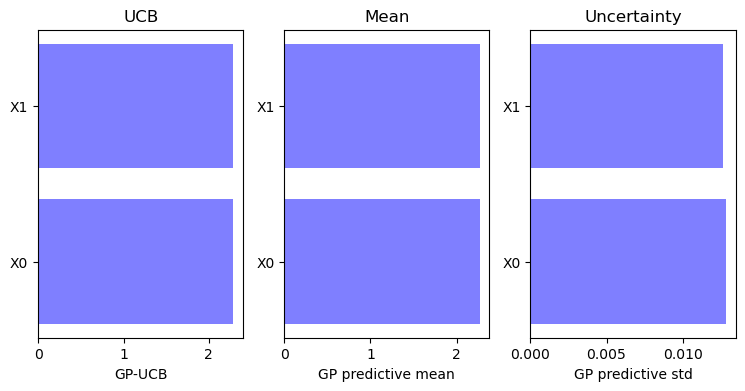

Do you want to know the attribution to each feature?
Type y if yes, otherwise type n as non
Do you want to visualise the GP on the plane where two candidates are placed?
Type y if yes, otherwise type n as non
Do you want to visualise the learnt preference model on the plane where two candidates are placed?
Type y if yes, otherwise type n as non
Type 0 or 1 which you think larger. Type 2 if unsure.1
You chose X1
Probability of correct selection: 7.14e-01 ± 1.00e-01
Estimated total correct selection rate of sure samples: 6.13e-01 ± 1.97e-01
Is your selection correct? Yes if 1: 1
Is your selection sure? Yes if 1: 1
37) Best value: 1.06025e+01
7) parameters: beta 1.600e+00 gamma 4.900e-01 sigma 1.250e-02
training models...
generating candidates...
X1 (normal UCB): tensor([-1.0313, -1.0238])
X0 (preference): tensor([-1.0337, -1.0238])
Do you need more explanation on the two candidates?
Type y if yes, otherwise type n as non
Do you want to know the attribution to each feature?
Type y if yes,

generating candidates...
X1 (normal UCB): tensor([-1.0319, -1.0273])
X0 (preference): tensor([-1.0336, -1.0264])
Do you need more explanation on the two candidates?
Type y if yes, otherwise type n as non
Do you want to know the attribution to each feature?
Type y if yes, otherwise type n as non
Do you want to visualise the GP on the plane where two candidates are placed?
Type y if yes, otherwise type n as non
Do you want to visualise the learnt preference model on the plane where two candidates are placed?
Type y if yes, otherwise type n as non
Type 0 or 1 which you think larger. Type 2 if unsure.2
You are unsure. We follow BO recommendation.
Probability of correct selection: 5.10e-01 ± 5.88e-03
Estimated total correct selection rate of sure samples: 5.67e-01 ± 2.54e-01
Is your selection correct? Yes if 1: 1
Is your selection sure? Yes if 1: 0
46) Best value: 1.06029e+01
16) parameters: beta 2.332e+00 gamma 2.560e+00 sigma 5.882e-03
training models...
generating candidates...
X1 (norma

In [7]:
results = []
for t in range(n_iterations):
    beta, gamma, radius = state(t)
    dataset_obj, dataset_duel, result = xbo(
        dataset_obj, dataset_duel, beta, gamma,
    )
    print(f"{len(dataset_obj[0])}) Best value: {dataset_obj[1].max().item():.5e}")
    results.append(result)

results = torch.tensor(results)

# Results
[overhead(s), best observation, Euclidean distance, correct answer, sure answer]

In [8]:
results

tensor([[1.2216e+01, 7.1627e+00, 2.1782e-01, 1.0000e+00, 1.0000e+00],
        [2.1846e+01, 8.1238e+00, 1.1593e-01, 1.0000e+00, 1.0000e+00],
        [2.0302e+01, 8.5708e+00, 4.7217e-02, 1.0000e+00, 1.0000e+00],
        [1.4109e+01, 1.0181e+01, 6.7441e-02, 1.0000e+00, 1.0000e+00],
        [8.7700e+00, 1.0566e+01, 1.6304e-01, 1.0000e+00, 1.0000e+00],
        [1.2357e+01, 1.0566e+01, 3.8712e-02, 0.0000e+00, 1.0000e+00],
        [1.4782e+01, 1.0569e+01, 5.0701e-03, 1.0000e+00, 1.0000e+00],
        [8.1729e+00, 1.0602e+01, 9.8279e-03, 1.0000e+00, 1.0000e+00],
        [8.4166e+00, 1.0603e+01, 6.9332e-03, 1.0000e+00, 1.0000e+00],
        [7.9332e+00, 1.0603e+01, 6.9505e-03, 0.0000e+00, 1.0000e+00],
        [7.2559e+00, 1.0603e+01, 7.5564e-03, 1.0000e+00, 1.0000e+00],
        [8.4727e+00, 1.0603e+01, 7.9136e-03, 1.0000e+00, 1.0000e+00],
        [9.3671e+00, 1.0603e+01, 1.2693e-02, 0.0000e+00, 1.0000e+00],
        [7.1818e+00, 1.0603e+01, 5.5029e-03, 1.0000e+00, 1.0000e+00],
        [6.6187e+00,